Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/My Drive/NeuralNetworksProject/"

In [ ]:
import datetime
import csv
import numpy as np

first_day = datetime.datetime.strptime('10/1/2013', '%m/%d/%Y')
last_day = datetime.datetime.strptime('12/31/2022', '%m/%d/%Y')

def get_trading_days(file_name):
  # first_day = first_day
  days = []
  with open(file_name + '.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    spamreader.__next__()
    for row in spamreader:
        cur_date = datetime.datetime.strptime(row[0], '%m/%d/%Y')
        if first_day <= cur_date and cur_date <= last_day:
          days.append(cur_date)

    return days

In [ ]:
trading_days = get_trading_days(data_path + "SandPPrices")


In [ ]:
def get_values(date_line, line_wanted, date_format, fine_name):
  data = []
  with open(data_path + fine_name + '.csv', newline='') as csvfile:
      spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
      spamreader.__next__()
      for row in spamreader:
          try:
            if row[date_line] != '':
              cur_date = datetime.datetime.strptime(row[date_line], date_format)
              data.append([cur_date, row[line_wanted]])
          except:
            print(row)
  # check to make sure you have every day
  value_data = np.zeros(len(trading_days))
  data_idx = 0
  for days_idx in range(len(trading_days)):
    # if current date we are looking for is between the current and the next available piece of data
    # take the current data
    if data_idx + 1 < len(data) and trading_days[days_idx] >= data[data_idx][0] and trading_days[days_idx] < data[data_idx + 1][0]:
      value_data[days_idx] = data[data_idx][1]

    # if it is not the iterate through the data until it is
    else:
      while(data_idx + 1 < len(data) and trading_days[days_idx] >= data[data_idx + 1][0]):
        data_idx += 1
      value_data[days_idx] = data[data_idx][1]


  return(value_data)

In [ ]:
SandPData = np.array(get_values(0, 1, '%m/%d/%Y', "SandPPrices"))
RealEstateData = np.array(get_values(0, 1, '%m/%d/%Y', "RealEstateIndexDailySince2013"))
BondData = np.array(get_values(0, 1, '%m/%d/%Y', "isharesBondIndexSince2003"))

with open('/content/drive/My Drive/stochastic_stocks.csv', 'w', newline='') as file:
     writer = csv.writer(file)
     for data in SandPData:
       writer.writerow([data])
with open('/content/drive/My Drive/stochastic_bond.csv', 'w', newline='') as file:
     writer = csv.writer(file)
     for data in BondData:
       writer.writerow([data])
with open('/content/drive/My Drive/stochastic_re.csv', 'w', newline='') as file:
     writer = csv.writer(file)
     for data in RealEstateData:
       writer.writerow([data])

print(len(SandPData))
print(len(RealEstateData))
print(len(BondData))

2330
2330
2330


In [ ]:
stock_train = SandPData[:int(len(SandPData) * .9)]
stock_test = SandPData[int(len(SandPData) * .9) : ]
bond_train = BondData[:int(len(BondData) * .9)]
bond_test = BondData[int(len(BondData) * .9) : ]
re_train = RealEstateData[:int(len(RealEstateData)* .9)]
re_test = RealEstateData[int(len(RealEstateData) * .9) : ]

print(len(stock_train))
print(len(bond_train))
print(len(re_train))
print(len(stock_test))
print(len(bond_test))
print(len(re_test))

2097
2097
2097
233
233
233


Get TPM

In [ ]:
import itertools
def state_to_idx():
  ## add for loops for more assets
  states = [-3, -2, -1, 1, 2, 3]
  ## create combos and assign idxs to them
  combos = {}
  index = 0
  for i in states:
    for j in states:
      for k in states:
        combos[str(i) + ","+ str(j) + "," + str(k)] = index
        index += 1
  return combos

def unpack_state(state):
  state = state.split(',')
  for idx in range(len(state)):
    state[idx] = int(state[idx])
  return state

def pack_state(state):
  ret_state = ""
  for idx in range(len(state)):
    if idx < len(state) - 1:
      ret_state += str(state[idx]) + ","
    else:
      ret_state += str(state[idx])
  return ret_state


def get_new_state(cur_state, new_vec):
  cur_state = unpack_state(cur_state)
  for idx in range(len(cur_state)):
    if cur_state[idx] > 0 and new_vec[idx] > 0:
      if cur_state[idx] < 3:
        cur_state[idx] += 1
    elif cur_state[idx] < 0  and new_vec[idx] < 0:
      if cur_state[idx] > -3:
        cur_state[idx] -= 1
    elif new_vec[idx] > 0:
      cur_state[idx] = 1
    else:
      cur_state[idx] = -1

  return pack_state(cur_state)

def get_TPM_ETC(assets):
  assets = np.array(assets)
  state_to_idx_map = state_to_idx()
  changes_stocks = [[] for i in range(6**len(assets))]
  changes_bonds = [[] for i in range(6**len(assets))]
  changes_re = [[] for i in range(6**len(assets))]
  TPM = np.zeros((6**len(assets), 6**len(assets)))
  cur_state = get_new_state("0,0,0", assets[:, 0] - assets[:, 1])
  for i in range(1, assets.shape[1] - 1):
    new_state = get_new_state(cur_state, assets[:, i + 1] - assets[:, i])
    percent_change = (assets[:, i + 1]- assets[:, i] ) / assets[:, i]
    changes_stocks[state_to_idx_map[new_state]].append(percent_change[0])
    changes_bonds[state_to_idx_map[new_state]].append(percent_change[1])
    changes_re[state_to_idx_map[new_state]].append(percent_change[2])

    TPM[state_to_idx_map[cur_state], state_to_idx_map[new_state]] += 1
    cur_state = new_state

  ## make a probability
  for idx in range(len(TPM)):
    row = TPM[idx]
    tot = sum(row)
    if tot == 0:
      ## make row uniform
      new_row = [1.0/(6**len(assets)) for i in range (6**len(assets))]
      TPM[idx] = new_row
    else:
      row = row/tot
      TPM[idx] = row

  ## get total std and mean for each



  flat_stock = list(itertools.chain.from_iterable(changes_stocks))
  flat_bond = list(itertools.chain.from_iterable(changes_bonds))
  flat_re = list(itertools.chain.from_iterable(changes_re))
  stock_mean = np.mean(flat_stock)
  bond_mean = np.mean(flat_bond)
  re_mean = np.mean(flat_re)
  stock_std = np.std(flat_stock)
  bond_std = np.std(flat_bond)
  re_std = np.std(flat_re)

  print(stock_mean)
  print(bond_mean)
  print(re_mean)
  print(stock_std)
  print(bond_std)
  print(re_std)

  print(np.mean(np.absolute(flat_stock)))
  print(np.mean(np.absolute(flat_bond)))
  print(np.mean(np.absolute(flat_re)))


  ## determine mean and
  stock_means = []
  bond_means = []
  re_means = []
  stock_stds = []
  bond_stds = []
  re_stds = []

  for idx in range(6**len(assets)):

    # calulate mean and std of each asset for each state
    # check for different conditions
    if len(changes_stocks[idx]) == 0:
      stock_means.append(stock_mean)
      stock_stds.append(stock_std)
    elif len(changes_stocks[idx]) == 1:
      stock_stds.append(stock_std)
      stock_means.append(changes_stocks[idx][0])
    else:
      stock_stds.append(np.std(changes_stocks[idx]))
      stock_means.append(np.mean(changes_stocks[idx]))

    if len(changes_bonds[idx]) == 0:
      bond_means.append(bond_mean)
      bond_stds.append(bond_std)
    elif len(changes_bonds[idx]) == 1:
      bond_stds.append(bond_std)
      bond_means.append(changes_bonds[idx][0])
    else:
      bond_stds.append(np.std(changes_bonds[idx]))
      bond_means.append(np.mean(changes_bonds[idx]))

    if len(changes_re[idx]) == 0:
      re_means.append(re_mean)
      re_stds.append(re_std)
    elif len(changes_re[idx]) == 1:
      re_stds.append(re_std)
      re_means.append(changes_re[idx][0])
    else:
      re_stds.append(np.std(changes_re[idx]))
      re_means.append(np.mean(changes_re[idx]))




  return TPM, stock_means, bond_means, re_means, stock_stds, bond_stds, re_stds, cur_state
TPM, stock_means, bond_means, re_means, stock_stds, bond_stds, re_stds, last_state = get_TPM_ETC([stock_train, bond_train, re_train])

print(stock_means)
# print(bond_means)
# print(re_means)
# print(stock_stds)
# print(bond_stds)
# print(re_stds)

0.0004949447602052107
2.2923623986292182e-05
0.0002925253974218122
0.009011525465267572
0.00250569086710637
0.01217493311869829
0.006128632207927833
0.001639150293426026
0.007687776845919039
[-0.012520196349176671, -0.005288364147147972, -0.023891143545305485, -0.008329729002263926, -0.0008906745303570951, 0.0004949447602052107, -0.0003922825784353562, -0.002673578440945071, -0.0033411256575909916, -0.006570955896393692, -0.0026766088077010966, 0.0004949447602052107, -0.01106345892500903, -0.004094259563060899, -0.0034565395948204713, -0.008394641068800038, -0.0017160282047487133, -0.002143888448502221, -0.01638440025076163, -0.004377388106641501, -0.005216913340338318, -0.008407456382232495, -0.00892092581878464, -0.010676598386095592, -0.011375414970480153, -0.013925820176857121, 0.0004949447602052107, -0.009246166002028437, -0.0011558744086255627, -0.002161312154386149, -0.021530489036556362, -0.006577245578951583, -0.007739868146890672, -0.007958446918046109, -0.005085152204435482,

## have std/mean for each asset and have TPM ##

## Now time to run monte carlo simulations on training data ##

In [ ]:
def run_simulation(TPM, means, stds, start_state):
  cur_ret = 1
  returns = []
  cur_state = start_state
  for i in range(10):
    cur_state = np.random.choice(len(TPM[cur_state]), p=TPM[cur_state])
    percent_change = np.random.normal(means[cur_state], stds[cur_state])
    cur_ret *= 1 + percent_change
  return cur_ret

In [ ]:
state_to_idx_map = state_to_idx()

In [ ]:
run_simulation(TPM, stock_means, stock_stds, state_to_idx_map[last_state])

1.0241590896224728

In [ ]:

def mean_simulation(TPM, means, stds, start_state):
  num_simulations = 100
  rets = []
  tot = 0
  for i in range(num_simulations):
    tot += run_simulation(TPM, stock_means, stock_stds, start_state)
    # rets.append(run_simulation(TPM, stock_means, stock_stds, start_state))
  return tot/num_simulations
  # return np.median(rets)

In [ ]:
mean_simulation(TPM, stock_means, stock_stds, state_to_idx_map[last_state])

0.9999855700870657

In [ ]:
import matplotlib.pyplot as plt
idx_to_state = {value: key for key, value in state_to_idx_map.items()}
def run_testing(TPM, means, stds, start_state, data, asset_idx):
  cur_state = state_to_idx_map[last_state]
  per_pred = []
  val_pred = []
  actual_percent = []
  actual_val = []
  start_val = []
  # NN_preds = [[0.006441447138786316, 0.01304445505142212, 0.012268587350845336, 0.017599505186080933, 0.014510058164596558, 0.012967418432235717, 0.01312045693397522, 0.011616851091384888, 0.010282695293426514, 0.013118655681610107, 0.013486430644989014, 0.02633359670639038, 0.012615240812301635, 0.016337231397628785, 0.012208269834518433, 0.0038724297285079954, 0.003704788088798523, 0.008404284119606018, 0.015233327150344849, 0.010718351602554322, 0.01042486310005188, 0.00724968433380127, 0.005262901782989502],
  # [-0.004999701380729676, 0.00625458300113678, -0.0024692457914352417, 0.00924244463443756, 0.008469010591506959, -0.0027018660306930543, 0.004656429886817932, 0.005506942868232727, 0.0025652247667312623, 0.0031675606966018676, -0.0006817226856946945, 0.009179543852806091, 0.006969778537750244, 0.0005132443457841874, 0.0019239330291748048, -0.003858429789543152, -0.007330383658409118, 0.0005726880580186844, 0.004108421206474304, 0.005774076581001281, -0.003008832335472107, 4.541702568531037e-05, -0.0033949333429336547],
  # [0.00020457876846194267, 0.00020457876846194267, -0.001225382834672928, -0.0028081506490707396, 0.005438918471336365, -4.731783643364906e-05, 0.0015646909177303315, 0.0012077350914478301, 0.0008254773914813995, -0.001386980265378952, -0.0037575533986091616, 0.008335707783699036, -0.003575896620750427, -0.008905749320983886, 0.011645607948303223, 0.00020457876846194267, 0.001415587365627289, -0.00013677025213837624, -0.00022188832983374596, 0.000970449149608612, 0.0005499368906021118, 0.0002578466571867466, 0.0006216784566640854]]
  NN_preds = [[-0.002358940243721008, -0.007336111664772034, -0.0032664269208908083, -0.0012164752930402755, -0.006624431014060974, -0.0036456280946731566, -0.003451525568962097, -0.0017922800779342652, -0.0006656306236982345, -0.0026255720853805543, 0.001165049746632576, -0.007348902821540833, -0.005246908068656921, -0.005011404156684876, -0.003574368357658386, -0.000680125281214714, -0.0007012825459241867, 0.0006080979853868484, -0.004842936396598816, -0.005973498225212097, -0.002636367678642273, -0.004988860487937927, -0.004176090359687805],
  [-0.005708999037742615, 0.0012008626759052276, -0.004352280497550964, -0.005302421450614929, 0.0013941390812397003, -0.004516300559043884, -0.004108955264091492, -0.0032796424627304075, -0.003985006213188171, -0.0022159449756145476, -0.0042260998487472536, -0.0012650005519390106, -0.0013516299426555634, -0.0030607670545578004, -0.003917006850242615, -0.006224078536033631, -6.92741572856903e-05, -0.003966233134269715, -0.0023788397014141084, -0.0014553873240947723, -0.0043496149778366085, -0.0045354503393173215, -0.003654939532279968],
  [0.00879432737827301, 0.006858606934547424, 0.005812550187110901, 0.007657318711280823, 0.0043461379408836365, 0.005430575013160705, 0.006113935112953186, 0.0065332227945327755, 0.004863158166408539, 0.0042283543944358825, 0.00736399233341217, 0.005304980874061584, 0.004876829087734223, 0.003803740441799164, 0.004866476953029632, 0.006246071457862854, 0.005413375496864319, 0.005975943207740784, 0.005411081910133362, 0.003726159036159515, 0.004657698571681976, 0.004817539155483246, 0.005671373009681702]
  ]
  for i in range(len(data[0]) - 10):
    if i % 10 == 0:
      pred_per_change = mean_simulation(TPM, means, stds, cur_state)
      per_pred.append(pred_per_change - 1)
      val_pred.append(pred_per_change * data[asset_idx][i])
      actual_percent.append((data[asset_idx][i + 10] - data[asset_idx][i])/ data[asset_idx][i])
      actual_val.append(data[asset_idx][i + 10])
      start_val.append(data[asset_idx][i])

    cur_state = state_to_idx_map[get_new_state(idx_to_state[cur_state], data[:, i] - data[:, i + 1])]

  x_pred = [i * 10 for i in range(1, len(val_pred) + 1)]
  x_actual = [i for i in range(len(data[0]))]


  NN_actuals = []
  for idx, pred in enumerate(NN_preds[asset_idx]):
    NN_actuals.append(pred* start_val[idx] + start_val[idx])
  # print(per_pred)
  # print(actual_percent)
  plt.figure()
  plt.plot(x_actual, data[asset_idx],color='black', label = "True")
  plt.scatter(x_pred, val_pred)
  for x in x_pred:
    plt.axvline(x=x, color='r', linestyle='--')
  for idx, x in enumerate(x_pred):
    if idx == 0:
      plt.plot([x - 10, x], [data[asset_idx][x - 10], val_pred[idx]], color='g', label = "MC_pred")
    else:
      plt.plot([x - 10, x], [data[asset_idx][x - 10], val_pred[idx]], color='g')
  plt.scatter(x_pred, NN_actuals)
  for idx, x in enumerate(x_pred):
    if idx == 0:
      plt.plot([x - 10, x], [data[asset_idx][x - 10], NN_actuals[idx]], color='pink', label = "NN_pred")
    else:
      plt.plot([x - 10, x], [data[asset_idx][x - 10], NN_actuals[idx]], color='pink')
  plt.xlabel("Days")
  plt.ylabel("Asset Price")
  asset_name = "Real Estate"
  if asset_idx == 0:
    asset_name ="Stocks"
  if asset_idx == 1:
    asset_name = "Bonds"
  plt.title(asset_name + " Predictions")
  plt.legend()
  plt.show()

  tot_error = 0
  rel_error = 0
  print(per_pred)
  print(actual_percent)
  for idx in range(len(per_pred)):
    tot_error += abs(per_pred[idx] - actual_percent[idx])
    rel_error += abs(per_pred[idx] - actual_percent[idx]) / abs(actual_percent[idx])
  print(start_val)
  print(rel_error/len(per_pred))
  return tot_error/len(per_pred)

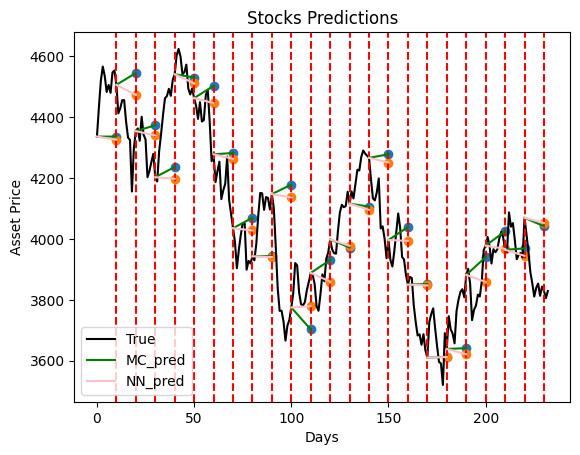

[-2.8735850945427188e-05, 0.008594134283028687, 0.004408996176717084, 0.00800797180150381, -0.0023853444672095048, 0.009030558215426199, 0.0009502380270169919, 0.008524006026799258, 0.00030508473002255343, 0.007536637556458503, -0.019138385256531665, 0.010964003748730411, -0.006668874429585525, -0.0023581502201064364, 0.002767178929696801, 0.010696987771063649, 0.00046242941887619793, 0.000871857767694495, 0.0006843880420848159, 0.01501809296430845, 0.011924658125245235, 0.001191762386037576, -0.0068215440183678755]
[0.039223373514537155, -0.03375297086060097, -0.034775858544797304, 0.08050443162215219, -0.017275588019616397, -0.041343240772278286, -0.05679103535648681, -0.02285895548649621, 0.05178369440062487, -0.08979966820347611, 0.030081781116960027, 0.02833401058571176, 0.029371528324867526, 0.03655120302633478, -0.06326778879171943, -0.036653079404162264, -0.06237288663890835, 0.00799771731241236, 0.06683797562282709, 0.024761389543645398, -0.003464078411853218, 0.02653505508060

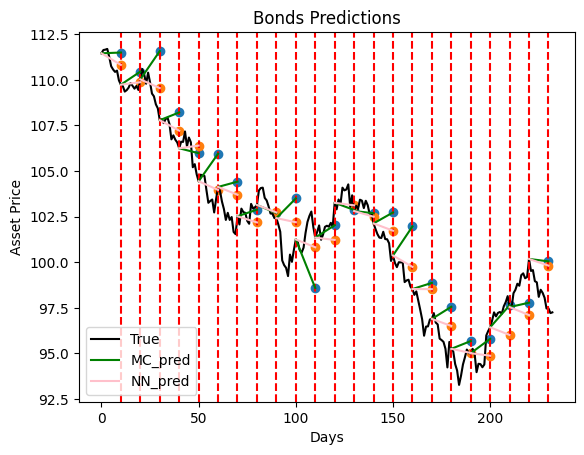

[0.00037274359881966923, 0.006519286859030915, 0.014095166387606106, 0.003946854570474834, -0.0025378808681589815, 0.014471827020270611, 0.0027921172903333513, 0.003549198502862616, -0.004310239831367024, 0.010540015771410172, -0.026302465158518973, 0.0066976755410121935, -0.003798944704534346, -0.0012086225306470189, 0.005866964820778753, 0.01586788601244482, 0.0034066495390547846, 0.006863014856221428, 0.004466301042193699, 0.008307330245816535, 0.012568435970273795, 0.00246728171254329, -0.0013245659598314363]
[-0.01543155405913826, 0.0026426189656027126, -0.020358066167027775, -0.014287048758817655, -0.017035275294117583, -0.0029682592307878723, -0.015461442873180908, 0.006047620153558915, -0.006980812555563398, -0.011423530783509746, 0.0009876345679012283, 0.018845624446879622, -0.004357970087972756, -0.006614152448480644, -0.017232880169378698, -0.018332210272027125, -0.016644676917128565, -0.016926401248079308, -0.00251966404199475, 0.014945773814424367, 0.011510950948874799, 0.

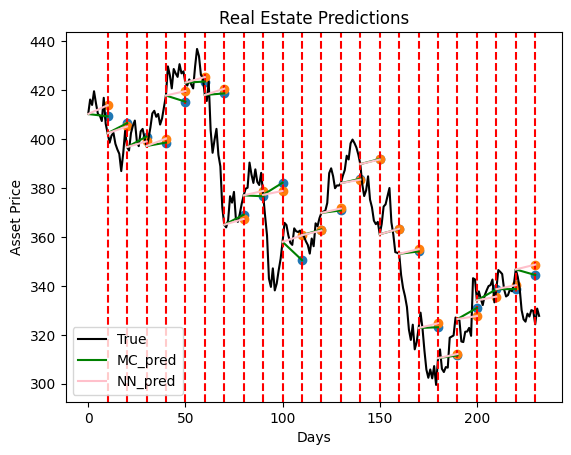

[-0.00232329402123721, 0.010249116376213507, 0.010780093734518825, 0.003545755939142081, -0.00604165152780578, 0.0010365477469900242, 0.0015412206851876942, 0.011223970444724785, -0.0009656641191004844, 0.013130842486452465, -0.02088306078610591, 0.006333274320248661, 0.0027428016948314315, 0.004778922334109037, 0.005426236871216572, 0.006045794748797739, 0.002743827460356396, 0.0010221871426943085, 0.0035551714252910482, 0.013951934146646972, 0.013602672524397175, 9.990254111036379e-05, -0.006606083944005636]
[-0.019155314015548357, -0.014013466842249219, 0.001007988307335721, 0.05203534476248007, 0.012610672409667477, -0.011933738213956593, -0.12694920118626227, 0.03290050405435018, 0.0005834769924412423, -0.050997959021390545, 0.0076809205932463764, 0.025223127667830875, 0.032848491402617, 0.02041724471900116, -0.07359618295154298, -0.02215207398792712, -0.08597156934926663, -0.03813743106760006, 0.05150256063387751, 0.023341297555596413, 0.013769157088122675, 0.023857328451635715, 

In [ ]:
print(run_testing(TPM, stock_means, stock_stds, last_state, np.array([stock_test, bond_test, re_test]), 0))
print(run_testing(TPM, bond_means, bond_stds, last_state, np.array([stock_test, bond_test, re_test]), 1))
print(run_testing(TPM, re_means, re_stds, last_state, np.array([stock_test, bond_test, re_test]), 2))

In [ ]:
def run_simu():
  test = np.arange(0, 11)

  np.random.shuffle(test)

  sum = 0
  for idx, x in enumerate(test):
    sum += abs(idx - x)
  return sum/11.0

reps = 10000
sum = 0
for i in range(reps):
  sum += run_simu()

print(sum/reps)

3.637509090909076
